<a href="https://colab.research.google.com/github/Naveen-King/Book-Recommendation-System/blob/main/Unsupervised_ML_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <font size="+2" color='#053c96'><b> Project Name </b></font>

$\color{red}{\text{Book Recommendation System}}$

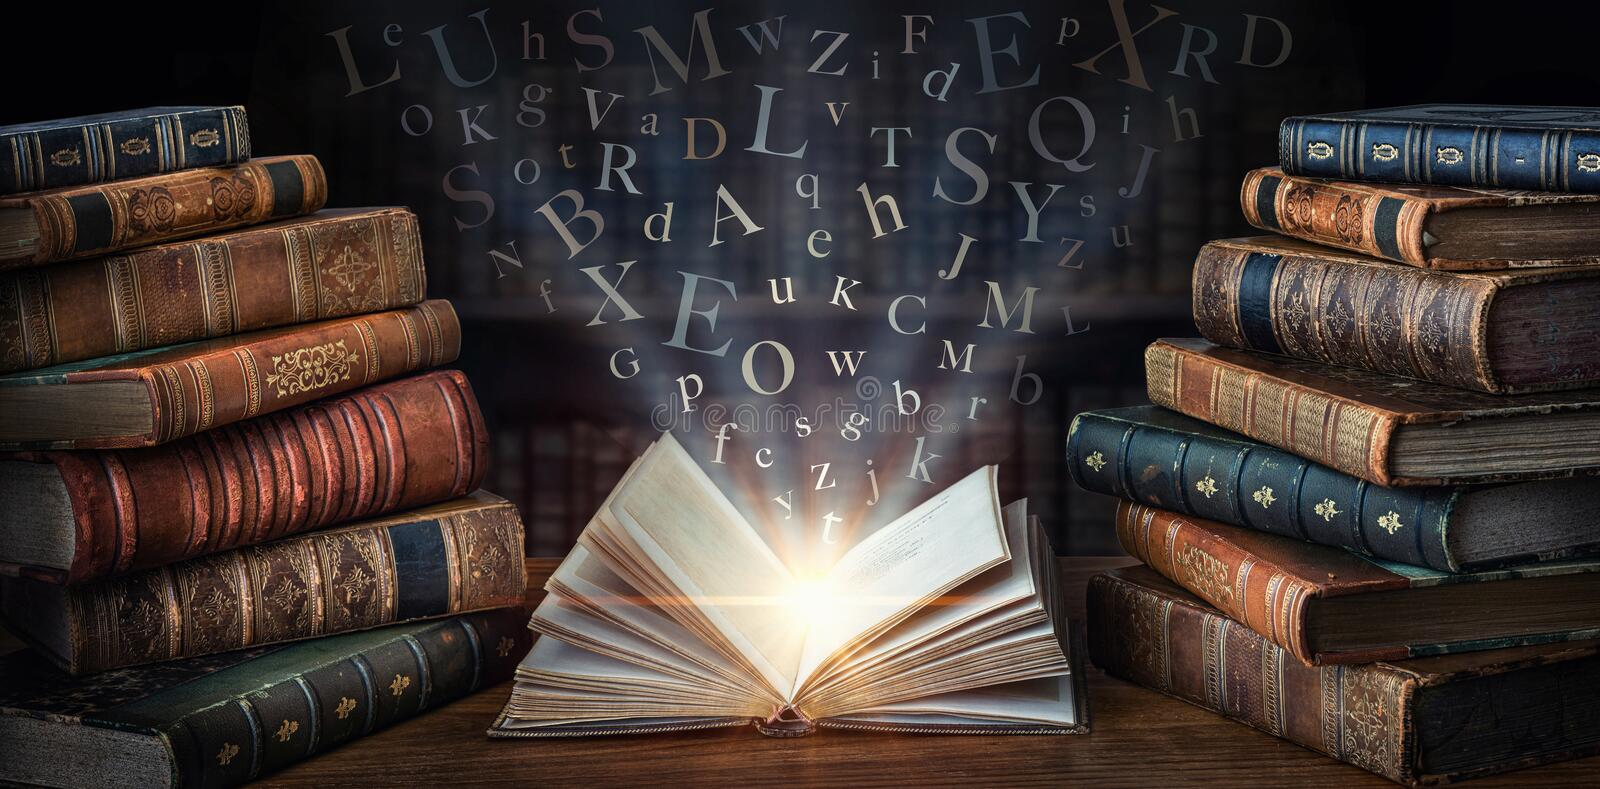

##### **Project Type**    - Unsupervised ML
##### **Contribution**    - Individual
##### **Team Member 1**-  $\color{green}{\text{Navneet Singh}}$


#<font size="+2" color='#053c96'><b> Problem Statement </b></font>

This is a Unsupervised Machine Learning Capstone Project. In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries). Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors.

The main objective is to create a book recommendation system for users.

#<font size="+2" color='#053c96'><b> GitHub Link </b></font>

https://github.com/Naveen-King/Book-Recommendation-System

#<font size="+2" color='#053c96'><b> Understanding the Data </b></font>

The Book-Crossing dataset comprises 3 files:

● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

● Ratings

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

#<font size="+2" color='#053c96'><b> Project Workflow </b></font>

1. Importing Libraries

2. Loading the Dataset

3. Data Cleaning

4. Feature Engineering

5. EDA 

6. Building Recommender System

# **1. Importing Libraries**

In [349]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [350]:
from __future__ import print_function

In [351]:
#importing the necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [352]:
# Read in the datasets
df_books = pd.read_csv('/content/drive/MyDrive/Capstone Project/Books.csv')
df_ratings = pd.read_csv('/content/drive/MyDrive/Capstone Project/Books_Ratings.csv')
df_user = pd.read_csv('/content/drive/MyDrive/Capstone Project/Books_Users.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## **1. Preliminary Analysis**

### A) Removing the Duplicates in the Books Data Frame Before Mergeing

In [353]:
#filling the missing values with 'Unknown'
df_books['Book-Author'].fillna('Unknown',inplace=True)

In [354]:
# Define a function to combine to columns namely title and author
def change_title(str1,str2):
  '''Change the title of books'''
  str1 = str1 +" "+'by' +" "+str2
  return str1

In [355]:
#shape of the dataframe before removing the duplicates
df_books.shape

(271360, 8)

In [356]:
# Create a new column for title
df_books['new_title'] = df_books.apply(lambda x : change_title(x['Book-Title'],x['Book-Author']),axis = 1)

In [357]:
# Get rid of duplications
df_books = df_books.drop_duplicates(subset='new_title',keep='first')

In [358]:
#shape of the dataframe after removing the duplicates
df_books.shape

(251185, 9)

In [359]:
271360-251185

20175

We can see that there were 20175 duplicates in books dataframe.

In [360]:
# defining print as p
p=print

In [361]:
#merging all the three dataset
df_merged = df_ratings.merge(df_books,how='inner',on='ISBN')
df_merged = df_merged.merge(df_user,how='inner',on='User-ID')

In [362]:
df_merged.shape

(916933, 13)

In [363]:
#adding a new column that measures the length of the title
df_merged['Title-Length'] = df_merged['Book-Title'].apply(len)
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')

In [364]:
#description of the features
df_merged.describe(include='all')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Length
count,916933.00000,916933,916933.000000,916933,916933,916933.000000,916931,916933,916933,916929,916933,916933,671659.000000,916933.000000
unique,NaN,250075,NaN,241061,101587,NaN,16542,250074,250074,250071,250075,21418,NaN,NaN
top,NaN,0971880107,NaN,Wild Animus,Nora Roberts,NaN,Ballantine Books,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus by Rich Shapero,"toronto, ontario, canada",NaN,NaN
freq,NaN,2502,NaN,2502,7645,NaN,30011,2502,2502,2502,2502,13115,NaN,NaN
mean,140202.83165,NaN,2.825417,NaN,NaN,1968.353922,NaN,NaN,NaN,NaN,NaN,NaN,37.340037,34.243288
std,80804.41894,NaN,3.848183,NaN,NaN,230.251189,NaN,NaN,NaN,NaN,NaN,NaN,14.073900,23.618870
min,2.00000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,69697.00000,NaN,0.000000,NaN,NaN,1991.000000,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,16.000000
50%,140410.00000,NaN,0.000000,NaN,NaN,1997.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,28.000000
75%,211426.00000,NaN,7.000000,NaN,NaN,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,48.000000


In [365]:
#information of the features
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916933 entries, 0 to 916932
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              916933 non-null  int64  
 1   ISBN                 916933 non-null  object 
 2   Book-Rating          916933 non-null  int64  
 3   Book-Title           916933 non-null  object 
 4   Book-Author          916933 non-null  object 
 5   Year-Of-Publication  916933 non-null  int64  
 6   Publisher            916931 non-null  object 
 7   Image-URL-S          916933 non-null  object 
 8   Image-URL-M          916933 non-null  object 
 9   Image-URL-L          916929 non-null  object 
 10  new_title            916933 non-null  object 
 11  Location             916933 non-null  object 
 12  Age                  671659 non-null  float64
 13  Title-Length         916933 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 104.9+ MB


In [366]:
916933-671659

245274

### There are 245274 missing values in the age column.

In [367]:
df_merged.loc[df_merged['ISBN'].str.endswith('X')].head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Length
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"tyler, texas, usa",NaN,20
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"cincinnati, ohio, usa",23.0,20
30,2313,080901548X,0,The Dark Child : The Autobiography of an Afric...,Camara Laye,1954,"Farrar, Straus and Giroux",http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,The Dark Child : The Autobiography of an Afric...,"cincinnati, ohio, usa",23.0,52


## **Conclusion**: Some titles have same ISBN.

## B) Unique Book Titles

In [368]:
len(df_merged['Book-Title'].unique())

241061

## C) Unique ISBNs

In [369]:
len(df_merged['ISBN'].unique())

250075

## D) Unique Users


In [370]:
len(df_merged['User-ID'].unique())

85504

## E) Publication Years

In [371]:
df_merged['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970, 1978, 1993,
       1989, 1995, 1990, 1992, 1950, 1991, 1999, 1954, 1988, 2003, 2004,
       2000, 1983, 1985, 1982, 1956, 1979, 1986, 1975,    0, 1976, 1977,
       1980, 1981, 1974, 1957, 1958, 1960, 1963, 1969, 1972, 1961, 1971,
       1953, 1968, 1973, 1967, 1962, 1937, 1959, 1955, 2005, 1945, 1965,
       1964, 1927, 2020, 2050, 1920, 1966, 1952, 1930, 1940, 1942, 1947,
       1925, 1923, 2030, 1951, 1936, 1946, 1943, 2099, 1928, 1941, 2011,
       1948, 1901, 1932, 1939, 1944, 1938, 1902, 1929, 1900, 1911, 1949,
       1926, 1933, 1922, 1897, 2026, 1906, 1806, 1935, 2006, 2037, 1921,
       2024, 2038, 1924, 1378, 2008, 1934, 1909, 1931, 1904, 1917, 2012,
       1914, 1376, 1908, 1919])

## **Observation:-** We can clearly see that their are some noise values in the Year of Publication features :-
### 1. **String Noise Values -** such as 'DK Publishing Inc' and 'Gallimard.
### 2. **Integer Noise Values -** Since this data was collected in august 2004, so any year value greater than 2004 is a noise value.

In [372]:
len(df_merged['Publisher'].unique())

16543

# **2. Preprocessing and Feature Engineering**

## 1. Location

In [373]:
# defining a function to extarct the country names
def get_country(x):
  return x.split(',')[-1]

In [374]:
#applying the function the location column
df_location = df_user.copy(deep=True)
df_location['country'] = df_user['Location'].apply(get_country)

In [375]:
df_merged['Location'] = df_merged['Location'].apply(get_country)

Extracted just the country names from the location column.

## 2. Age

### a) Creating bins for the age column.

In [376]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
df_merged['age_bins'] = pd.cut(x=df_merged['Age'], bins=bins,labels=labels)

### Labelled 'Kid' for values between between 1-12
### 'Teenager' for values between 13-19
### 'Adult' for values between 20-50
### 'Old' for values greater than 50

### b) Capping Outlier



In [377]:
# Number of outliers
outliers = sum(df_merged['Age']>90)
print(outliers)

2872


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


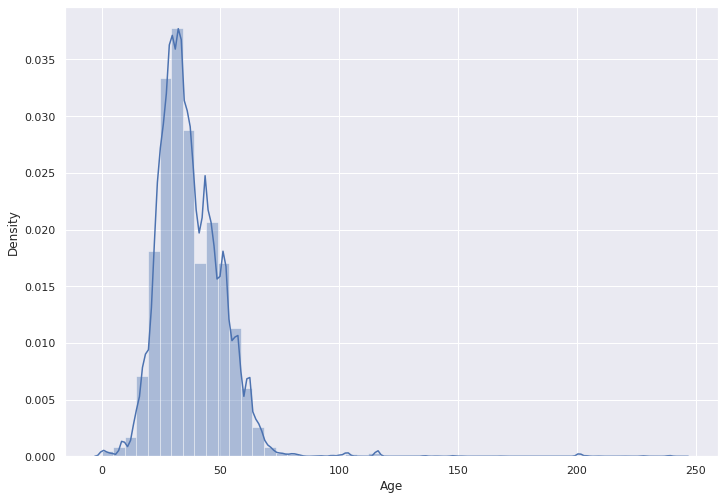

In [378]:
# Plot Distribution of Age
sns.distplot(df_merged['Age'].dropna())
# Handling outliers by randomly replacing age >90 by values between 90 and 100
age2 = df_merged['Age'].copy()
random_age2 = np.random.randint(90,100,outliers)
age2[df_merged['Age']>90]=random_age2
df_merged['Age'] = age2

##3.Handling Missing Value

In [379]:
# Missing Value Count Function
def show_missing(y):
    missing = y.columns[y.isnull().any()].tolist()
    return missing

def print_missing(x):
  # Missing data counts and percentage
  print('Missing Data Count')
  print(x[show_missing(x)].isnull().sum().sort_values(ascending = False))
  print('--'*50)
  print('Missing Data Percentage')
  print(round(x[show_missing(x)].isnull().sum().sort_values(ascending = False)/len(x)*100,2))

### Missing values for different features

In [380]:
print_missing(df_user)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [381]:
print_missing(df_location)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [382]:
print_missing(df_merged)

Missing Data Count
age_bins       247826
Age            245274
Image-URL-L         4
Publisher           2
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
age_bins       27.03
Age            26.75
Image-URL-L     0.00
Publisher       0.00
dtype: float64


###a) Dealing with the missing values of age.

In [383]:
# Null values in age column
nulls = sum(df_merged['Age'].isnull())
print('Null values in Age: ',nulls)

Null values in Age:  245274


In [384]:
# Replacing null values
median = df_merged['Age'].median()
std = df_merged['Age'].std()
random_age = np.random.randint(median - std, median + std, size = nulls)
age = df_merged['Age'].copy()
age[pd.isnull(age)] = random_age
df_merged['Age'] = age
df_merged['Age'] = df_merged['Age'].astype(int)

In [385]:
df_merged.shape

(916933, 15)

## 4. Calculating the Rating Count and Rating Mean for each Book-Title

In [386]:
# Calculating the rating count and mean rating given to each book by the user.

rating_count = df_merged.groupby('Book-Title')['Book-Rating'].count().to_frame()
rating_mean = df_merged.groupby('Book-Title')['Book-Rating'].mean().to_frame()

In [387]:
# Renaming the column names before merging them with the final dataset.

rating_count.rename(columns={'Book-Rating':'Rating-Count'}, inplace=True)
rating_mean.rename(columns={'Book-Rating':'Rating-Mean'}, inplace=True)

In [388]:
df_merged = pd.merge(df_merged, rating_count, on='Book-Title', how='inner')
df_merged = pd.merge(df_merged, rating_mean, on='Book-Title', how='inner')

In [389]:
# rounding off the rating mean feature to 2 decimal points
df_merged['Rating-Mean'] = df_merged['Rating-Mean'].round(2)

In [390]:
df_merged.drop(columns=['Image-URL-M','Image-URL-S','Image-URL-L'],inplace=True)

In [391]:
df_merged.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,35,20,NaN,60,2.93
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93


## 5.Using IMDB Formula to calculate the Weighted Rating for our books

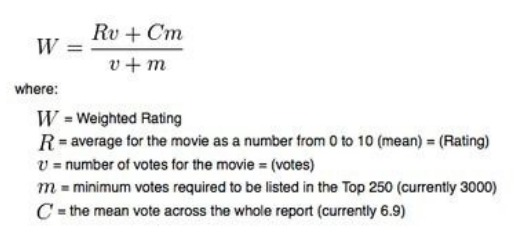

In [392]:
# Calculating the mean vote across the whole df
C = df_merged['Rating-Mean'].mean()

In [393]:
# Calculating the minimum votes required to be listed in the top 5%
m = rating_count.quantile(.95)[0]

In [394]:
# IMDB formula; source: https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/
def weighted_rating(x, m=m, C=C):
    v = x['Rating-Count']
    R = x['Rating-Mean']

    return (v/(v+m) * R) + (m/(m+v) * C)

## **Splitting the Dataset into Two Based on the Explicit and Implicit Ratings**

In [395]:
df_merged_updated=df_merged[df_merged['Book-Rating']!=0]

In [396]:
p(f" Implicit dataset has {df_merged.shape[0]-df_merged_updated.shape[0]} observations")
p(f" Explicit dataset has {df_merged_updated.shape[0]} observations")

 Implicit dataset has 576893 observations
 Explicit dataset has 340040 observations


In [397]:
# Create relevant sub-dataset
df_top_10 = df_merged_updated.copy().loc[df_merged_updated['Rating-Count'] >= m]
df_top_10.shape

(163365, 14)

In [398]:
df_top_10['Score'] = df_top_10.apply(weighted_rating, axis=1)

# **3. Exploratory Data Analysis**

##1. Ratings Count

### a) Explicit+Implicit Ratings

In [399]:
rating_count=df_ratings['Book-Rating'].value_counts().reset_index().sort_values('Book-Rating',ascending=False)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Ratings Count')

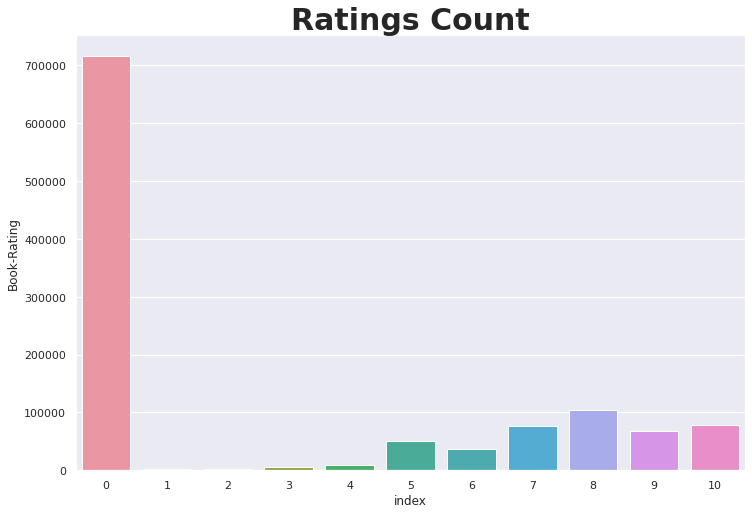

In [400]:
plt.figure(figsize=(12,8))
ax=sns.barplot(rating_count['index'],rating_count['Book-Rating'])
ax.set_title('Ratings Count',fontsize=30,fontweight='bold')

### **Conclusion**: The datset with both explicit and implicit ratings is highly skewed toward the value of zero.

### b) Explicit Ratings

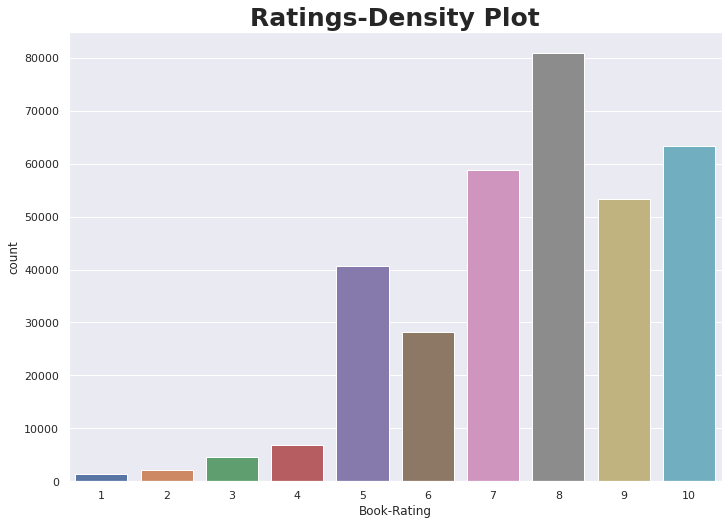

In [401]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# df_merged_updated = df_merged_updated[df_merged['Book-Rating']!=0]
sns.countplot(x='Book-Rating', data=df_merged_updated).set_title('Ratings-Density Plot', weight='bold').set_fontsize('25')

### **Conclusion**: The skewness perishes after we remove the implicit ratings.

## 2. Author V/S Ratings

In [402]:
# ratings count per author
auth_rating=df_merged.groupby(['Book-Author'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

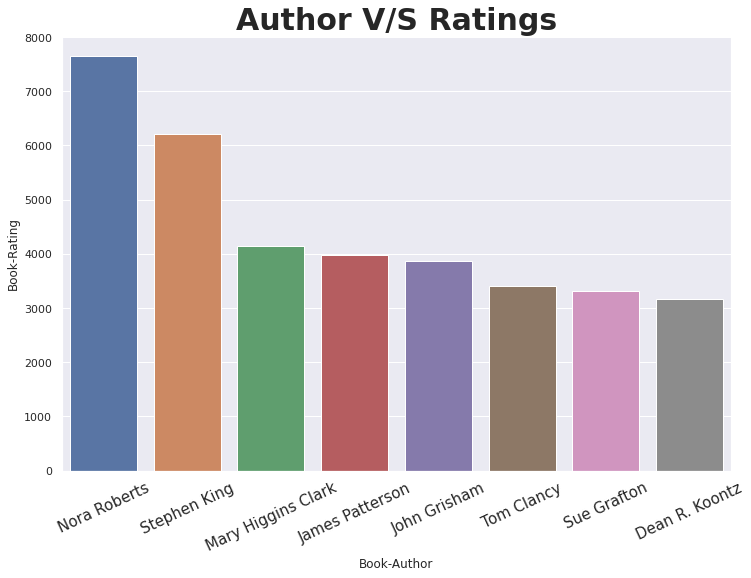

In [403]:
plt.figure(figsize=(12,8))
ax=sns.barplot(auth_rating[auth_rating['Book-Rating']>3000]['Book-Author'],auth_rating[auth_rating['Book-Rating']>3000]['Book-Rating'])
ax.set_title('Author V/S Ratings', fontsize=30,fontweight='bold')
plt.xticks(fontsize=15,rotation=25)

*   ### Here, we can observe, most frequently rated Authors.
*   ### Most frequently rated author is Nora Roberts, followed by Stephen King.

## 3. Book Ratings Count

In [404]:
#Book ratings count using group by
book_rating=df_merged.groupby(['Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

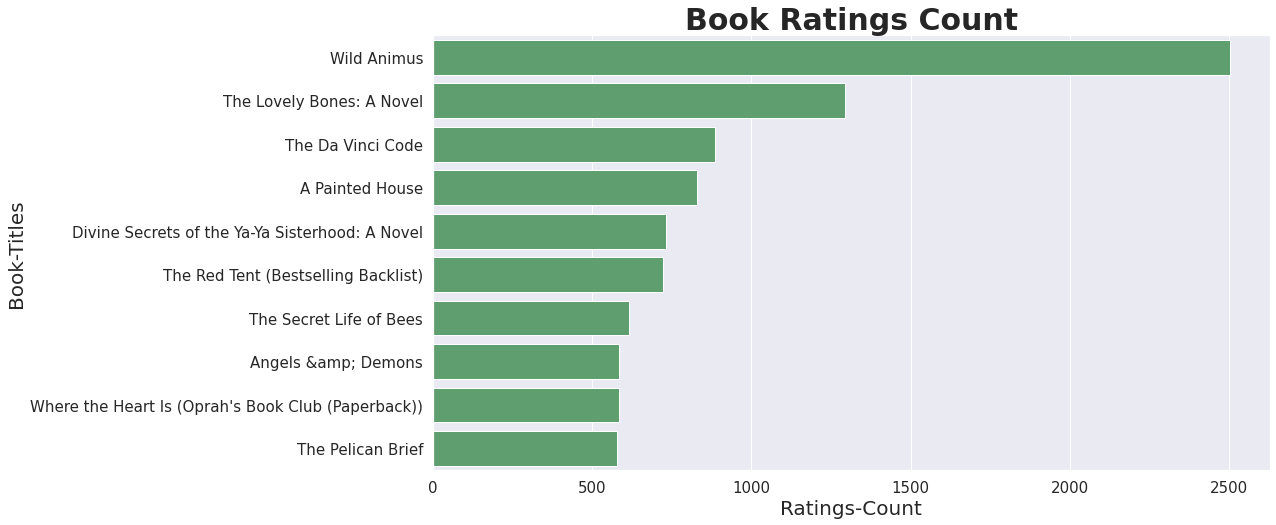

In [405]:
plt.figure(figsize=(15,8))
ax=sns.barplot(book_rating['Book-Rating'][:10],book_rating['Book-Title'][:10],color='g')
ax.set_title('Book Ratings Count', fontsize=30,fontweight='bold')
ax.set_xlabel('Ratings-Count',fontsize=20)
ax.set_ylabel('Book-Titles',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


*   ### Here, we are able to observe, most frequently rated books by the users.
*   ### Most frequently rated book, happens to be Wild Animuls.

## 4. Location

In [406]:
#Identifying what % of customers are coming from different countries
df_location = pd.DataFrame(df_location.country.value_counts(normalize=True)).reset_index()
df_location.columns = ['countries','value_counts']

#Labeling countries with low customer % as other
df_location['countries'] = df_location.apply(lambda x: 'other' if (x['value_counts'] < 0.01 or x['countries'] == '') else x['countries'],axis=1)

#Grouping the customer % from 'other' countries 
df_location = df_location.groupby('countries')['value_counts'].sum().reset_index()

In [407]:
#Every country has now just one occurance
df_location.countries.value_counts()

 australia         1
 canada            1
 france            1
 germany           1
 italy             1
 netherlands       1
 new zealand       1
 portugal          1
 spain             1
 united kingdom    1
 usa               1
other              1
Name: countries, dtype: int64

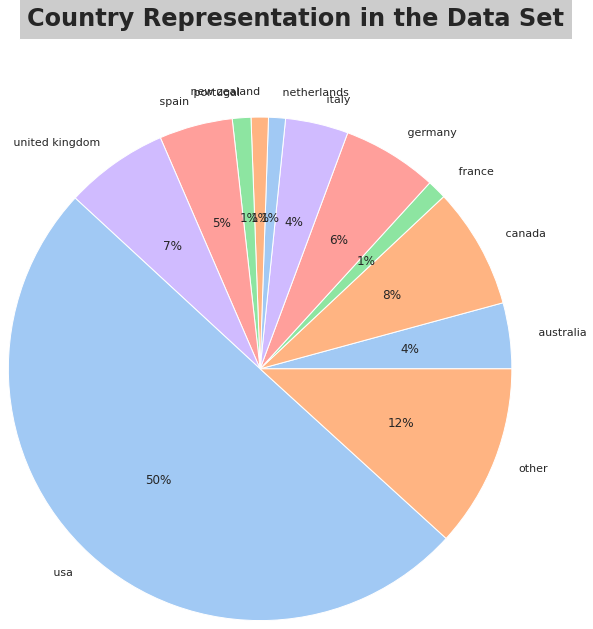

In [408]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title("Country Representation in the Data Set",bbox={'facecolor':'0.8', 'pad':8},fontsize=24, fontdict={"weight": "bold"},y=1.25,x=0.578)
f = plt.pie(df_location['value_counts'], labels = df_location['countries'], colors = colors, autopct='%.0f%%',radius=1.4)


*   ### Most customers are from United states of America, followd by Canada, United Kingdom and Germany.
*   ### Countries with less than 1% customers are labeled as other


## 4. Age vs Rating Density


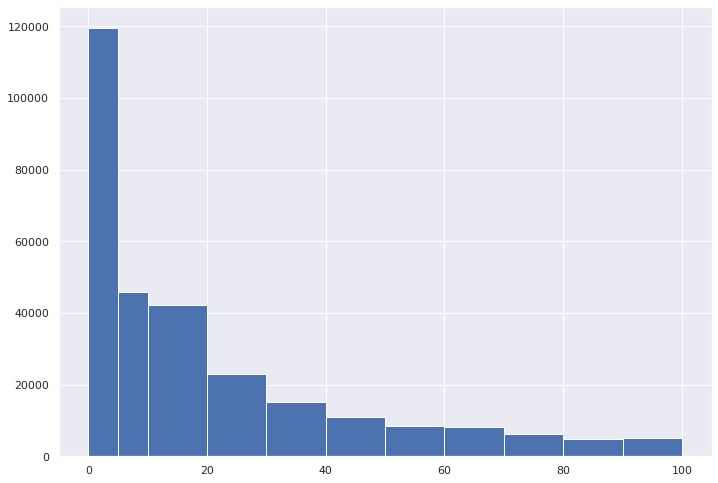

In [409]:
# Visualizing the rating counts of the users. 
df_merged_updated['Rating-Count'].hist(bins=[0,5,10,20,30,40,50,60,70,80,90,100])

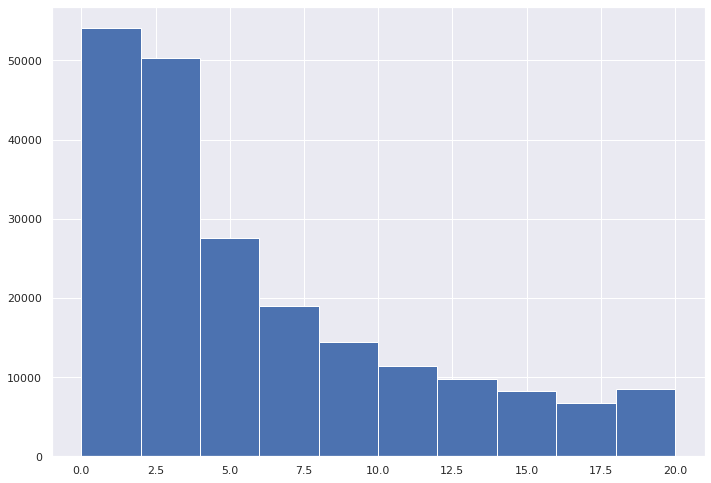

In [410]:
# Visualizing the rating counts of the users in the range between 0 to 20. 
df_merged_updated['Rating-Count'].hist(bins=[0,2,4,6,8,10,12,14,16,18,20])

## **From this visualization it is evident that most books have been rated by 2 to 5 users only.**

## 5. Age Bin Representation

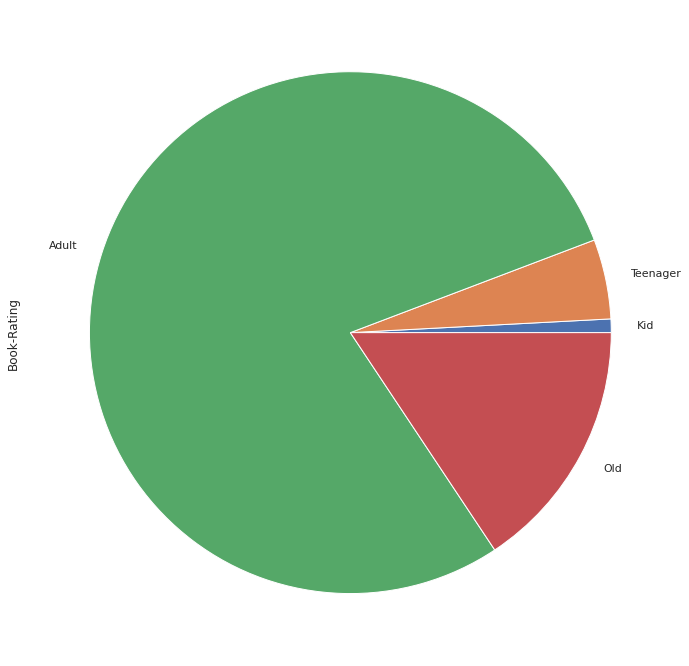

In [411]:
# Age group that rated books the most
plt.figure(figsize=(20,12))
df_merged.groupby('age_bins')['Book-Rating'].count().plot(kind='pie')

*   ### Most customers are Adults (20-50yrs).
* ### 2nd most represented age group is for boomers (>50yrs).



In [412]:
# Which country rates books the most
b1 = df_merged.groupby('Location')['Book-Rating'].count().sort_values(ascending=False).head(5)
b1

Location
 usa               660618
 canada             82214
 united kingdom     29795
 germany            26024
                    21364
Name: Book-Rating, dtype: int64

In [413]:
# Implicit ratings i.e. Book-Rating = 0
b2 = df_merged[df_merged['Book-Rating']==0].\
groupby('Location')['Book-Rating'].count().sort_values(ascending=False).head(5)

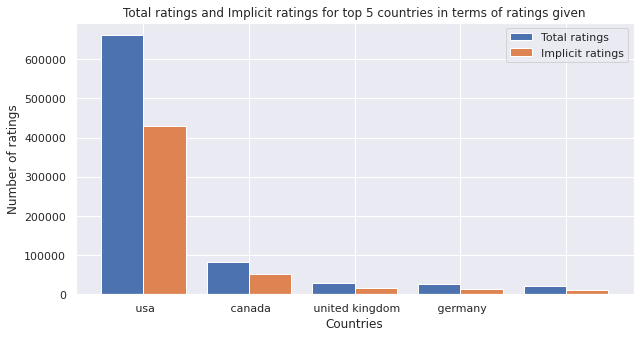

In [414]:
# Bar plot for Rating comparison 
n= 5
X_axis = np.arange(n)
X = b1.index

plt.figure(figsize=(10,5))  
plt.bar(X_axis - 0.2, b1, 0.4, label = 'Total ratings')
plt.bar(X_axis + 0.2, b2, 0.4, label = 'Implicit ratings')
  
plt.xticks(X_axis, X)
plt.xlabel("Countries")
plt.ylabel("Number of ratings")
plt.title("Total ratings and Implicit ratings for top 5 countries in terms of ratings given")
plt.legend()
plt.show()

In [415]:
# Most popular books for different age groups
age_bin_df = df_merged.groupby(['age_bins','Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()
age_bin_df.rename(columns={'Book-Title':'Number of times rated'},inplace=True)

### **Note**: Users from each age category can be said to have some similar book preferences, we will later use Age as a relevance to recommend books for implicit ratings.

# **4. Preparing the Data for Model Building.**


### Here the Year-Of-Publication is in object Dtype, it should ideally be in  numeric Dtype. Let us explore this feature a bit more.

## 1. Cleaning the Feature - Year of Publication

In [416]:
# Visually inspecting this feature by observing it's unique values.
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970,    0, 1978,
       1993, 1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988,
       2003, 2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976,
       1981, 1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961,
       1953, 1962, 1937, 1968, 1959, 1955, 2005, 1975, 1965, 1920, 1943,
       1964, 1967, 1927, 2020, 2050, 1952, 1966, 1930, 1940, 1942, 1946,
       1947, 1925, 1923, 2030, 1936, 1928, 1941, 1951, 1901, 2011, 1939,
       1945, 1932, 1902, 1929, 1911, 1949, 1926, 2026, 1906, 1806, 1933,
       1935, 1938, 2006, 2037, 1948, 2099, 2038, 1900, 1904, 1924, 1378,
       1934, 1944, 1931, 1376, 1908])

### Observation:-We can clearly see that their are some noice values in the Year of Publication features :-
### 1. String Noice Values - such as 'DK Publishing Inc' and 'Gallimard.
### 2. Integer Noice Values - Since this data was collected in august 2004, so any year value greater than 2004 is a noice value.

In [417]:
# Casting Year-Of-Publication to numeric datatype and removing all String Noice Values using coerce functionality.

df_merged_updated['Year-Of-Publication'] = pd.to_numeric(df_merged_updated['Year-Of-Publication'], 'coerce')

<ipython-input-417-a07179142885>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_updated['Year-Of-Publication'] = pd.to_numeric(df_merged_updated['Year-Of-Publication'], 'coerce')


In [418]:
# Cross checking the column to check if the string based noice values are removed or not.
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970,    0, 1978,
       1993, 1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988,
       2003, 2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976,
       1981, 1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961,
       1953, 1962, 1937, 1968, 1959, 1955, 2005, 1975, 1965, 1920, 1943,
       1964, 1967, 1927, 2020, 2050, 1952, 1966, 1930, 1940, 1942, 1946,
       1947, 1925, 1923, 2030, 1936, 1928, 1941, 1951, 1901, 2011, 1939,
       1945, 1932, 1902, 1929, 1911, 1949, 1926, 2026, 1906, 1806, 1933,
       1935, 1938, 2006, 2037, 1948, 2099, 2038, 1900, 1904, 1924, 1378,
       1934, 1944, 1931, 1376, 1908])

### Observaion: There are values like 2050, 2099 etc. which are not true.

In [419]:
# Removing all the integer Noice Values from the Dataset.
df_merged_updated = df_merged_updated[(df_merged_updated['Year-Of-Publication']<=2006)]
df_merged_updated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,2,20,Kid,60,2.93


In [420]:
df_merged_updated['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970,    0, 1978,
       1993, 1989, 1995, 1990, 1957, 1992, 1950, 1991, 1999, 1954, 1988,
       2003, 2004, 1977, 2000, 1983, 1985, 1986, 1982, 1956, 1979, 1976,
       1981, 1980, 1974, 1958, 1960, 1963, 1969, 1971, 1973, 1972, 1961,
       1953, 1962, 1937, 1968, 1959, 1955, 2005, 1975, 1965, 1920, 1943,
       1964, 1967, 1927, 1952, 1966, 1930, 1940, 1942, 1946, 1947, 1925,
       1923, 1936, 1928, 1941, 1951, 1901, 1939, 1945, 1932, 1902, 1929,
       1911, 1949, 1926, 1906, 1806, 1933, 1935, 1938, 2006, 1948, 1900,
       1904, 1924, 1378, 1934, 1944, 1931, 1376, 1908])

In [421]:
# The percentage of Data lost while cleaning the Year-of_publication Feature.
percentage_of_data_lost = (340040 - df_merged_updated.shape[0])*100/340040
percentage_of_data_lost

0.008528408422538524

### **Therefore, after cleaning the dataset based upon Year-Of-Publication Feature, we lost only a miniscule amount of 0.8% data.**

## 2. Selecting Books with Optimum Number of Ratings

* ### As we all know that building any recommendation system requires a lot of data. Recommendations should be relevant otherwise they can cause a nuisance to the customers. 
* ### So, we have set a threshold number of ratings per book in order to get optimal recommendations for our users.

In [422]:
# counting the ratings per ISBN
books_reduce=df_merged_updated.groupby(['ISBN'])['Book-Rating'].count().reset_index().sort_values('Book-Rating',ascending=False)

In [423]:
#Considering all the counts greater than 10
reduced_books=books_reduce[books_reduce['Book-Rating']>10]['ISBN']

In [424]:
#merging it with the original dataset
df_merged_updated=df_merged_updated.merge(reduced_books,how='inner',left_on='ISBN',right_on='ISBN')

In [425]:
df_merged_updated.shape

(112927, 14)

## 3. Defining the Optimum Book reader

*   ### We can't take every user's rating at facevalue because if the user is a novice reader with only an experience of reading a couple of books, his/her ratings might not be much relevant for finding similarity among books.

* ### Therefore as a general rule of thumb we choosing only those User's who have rated atleast 15 Books for builing the recommendation system.

In [426]:
# Size of dataset rows before the User selection operation.
df_size_before_removing_Novice_readers = df_merged_updated.shape[0]
df_size_before_removing_Novice_readers

112927

In [427]:
# Storing the value counts of User-ID's in a new variable named counts1
counts1 = df_merged_updated['User-ID'].value_counts()

# Removing the User-ID's which have rated less than 10 books.
df_merged_updated= df_merged_updated[df_merged_updated['User-ID'].isin(counts1[counts1 >=10].index)].reset_index()
df_merged_updated.drop(columns='index', inplace=True)

In [428]:
df_merged_updated.shape

(51937, 14)

In [429]:
# Size of dataset rows after the User selection operation.
df_size_after_removing_Novice_readers = df_merged_updated.shape[0]
df_size_after_removing_Novice_readers

51937

In [430]:
df_merged_updated.shape

(51937, 14)

# **5. Building Models**

## **1. Popularity Based Recommender System**



In [431]:
#Merging Books and Ratings dataframes
ratings_with_name = df_ratings.merge(df_books,on='ISBN')

In [432]:
#Counting number of rating for each book
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241056,Ã?Â?lpiraten.,2
241057,Ã?Â?rger mit Produkt X. Roman.,4
241058,Ã?Â?sterlich leben.,1
241059,Ã?Â?stlich der Berge.,3


In [433]:
#Calculating average rating for each book
avg_rating_df = ratings_with_name.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df

,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241056,Ã?Â?lpiraten.,0.000000
241057,Ã?Â?rger mit Produkt X. Roman.,5.250000
241058,Ã?Â?sterlich leben.,7.000000
241059,Ã?Â?stlich der Berge.,2.666667


In [434]:
#Merging num_rating and avg_rating dataframes on Book-Title column
popular_df = num_rating_df.merge(avg_rating_df,on='Book-Title')
popular_df

,Book-Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.250000
1,Always Have Popsicles,1,0.000000
2,Apple Magic (The Collector's series),1,0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.000000
...,...,...,...
241056,Ã?Â?lpiraten.,2,0.000000
241057,Ã?Â?rger mit Produkt X. Roman.,4,5.250000
241058,Ã?Â?sterlich leben.,1,7.000000
241059,Ã?Â?stlich der Berge.,3,2.666667


In [435]:
#Sorting top 50 books those who have received more than 250 ratings and highest average ratings
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(50)

In [436]:
popular_df = popular_df.merge(df_books,on='Book-Title')
popular_df

,Book-Title,num_ratings,avg_rating,ISBN,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title
0,Harry Potter and the Order of the Phoenix (Boo...,334,5.571856,043935806X,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,Harry Potter and the Order of the Phoenix (Boo...
1,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117,0345339681,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...,The Hobbit : The Enchanting Prelude to The Lor...
2,To Kill a Mockingbird,389,4.920308,0446310786,Harper Lee,1988,Little Brown &amp; Company,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,http://images.amazon.com/images/P/0446310786.0...,To Kill a Mockingbird by Harper Lee
3,Harry Potter and the Sorcerer's Stone (Harry P...,571,4.900175,059035342X,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,Harry Potter and the Sorcerer's Stone (Harry P...
4,The Fellowship of the Ring (The Lord of the Ri...,323,4.885449,0345339703,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,http://images.amazon.com/images/P/0345339703.0...,The Fellowship of the Ring (The Lord of the Ri...
...,...,...,...,...,...,...,...,...,...,...,...
58,Interview with the Vampire,506,3.535573,0345337662,Anne Rice,1993,Ballantine Books,http://images.amazon.com/images/P/0345337662.0...,http://images.amazon.com/images/P/0345337662.0...,http://images.amazon.com/images/P/0345337662.0...,Interview with the Vampire by Anne Rice
59,1st to Die: A Novel,391,3.498721,0446610038,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,1st to Die: A Novel by James Patterson
60,She's Come Undone (Oprah's Book Club (Paperback)),446,3.495516,0671003755,Wally Lamb,1996,Washington Square Press,http://images.amazon.com/images/P/0671003755.0...,http://images.amazon.com/images/P/0671003755.0...,http://images.amazon.com/images/P/0671003755.0...,She's Come Undone (Oprah's Book Club (Paperbac...
61,Two for the Dough,267,3.464419,0671001795,Janet Evanovich,1996,Pocket,http://images.amazon.com/images/P/0671001795.0...,http://images.amazon.com/images/P/0671001795.0...,http://images.amazon.com/images/P/0671001795.0...,Two for the Dough by Janet Evanovich


## **2. Collaborative Filtering Based Recommender System (User Based)**

In [437]:
#Selecting users who have given more than 200 ratings
#Merging Books and Ratings dataframes
ratings_with_name = df_ratings.merge(df_books,on='ISBN')
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
reliable_users = x[x].index

In [438]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(reliable_users)]

In [439]:
#Selecting top 50 books with highest number of rating 
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [440]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [441]:
#Applying Pivot table on final_ratings dataframe
pt = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [442]:
pt.fillna(0,inplace=True)
pt

User-ID,254,2276,2766,2977,3363,4385,6251,6323,6543,6575,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Case of Need,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Child Called \It\"": One Child's Courage to Survive""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Civil Action,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [443]:
#Applying cosine_similarity to pivot table
similarity_scores = cosine_similarity(pt)
similarity_scores.shape

(409, 409)

In [444]:
#Building recommender system
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = df_books[df_books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Year-Of-Publication'].values.astype(int)))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [445]:
recommend('Harry Potter and the Order of the Phoenix (Book 5)')

[['Harry Potter and the Goblet of Fire (Book 4)',
  'J. K. Rowling',
  2000,
  'http://images.amazon.com/images/P/0439139597.01.MZZZZZZZ.jpg'],
 ['Harry Potter and the Prisoner of Azkaban (Book 3)',
  'J. K. Rowling',
  1999,
  'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'],
 ["Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  'J. K. Rowling',
  1999,
  'http://images.amazon.com/images/P/059035342X.01.MZZZZZZZ.jpg'],
 ['A Wrinkle In Time',
  "MADELEINE L'ENGLE",
  1998,
  'http://images.amazon.com/images/P/0440498058.01.MZZZZZZZ.jpg']]

## **Singular Value Decomposition**

In [446]:
from scipy.sparse.linalg import svds
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(pt, k = NUMBER_OF_FACTORS_MF)

In [447]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [448]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-0.59768582,  0.04216288, -0.05703054, ...,  0.47596526,
         0.25120894,  0.14537382],
       [-0.01475727,  0.06159774,  0.13875482, ..., -0.01380264,
         0.03161906, -0.00138669],
       [-0.09194713,  0.21350239,  0.05029209, ...,  0.09579967,
         0.28211644, -0.05112645],
       ...,
       [ 0.37956128,  0.15406844,  0.43416758, ...,  0.20401527,
        -0.08539938,  0.25986992],
       [ 0.01027671,  0.0219068 , -0.19610455, ...,  0.32680078,
         0.2375498 ,  0.04988312],
       [-0.02128555,  0.19485755, -0.06073108, ...,  0.43593567,
         0.0489773 ,  0.02765055]])

In [449]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pt.columns, index=users_ids).transpose()
cf_preds_df.head(2)

,1st to Die: A Novel,4 Blondes,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Great Deliverance,A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Lesson Before Dying (Vintage Contemporaries (Paperback)),A Painted House,...,Whispers,White Oleander : A Novel (Oprah's Book Club),Wicked: The Life and Times of the Wicked Witch of the West,Wild Animus,Without Remorse,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
254,-0.597686,-0.014757,-0.091947,0.202038,-0.192892,-0.069376,-0.306112,0.022369,-0.043412,-0.143212,...,0.027039,0.196148,0.245845,0.063398,-0.019603,-0.333287,0.181439,0.379561,0.010277,-0.021286
2276,0.042163,0.061598,0.213502,0.109446,0.022265,0.140995,-0.025951,0.166548,0.109300,0.977368,...,0.078693,-0.159864,0.206119,0.122054,0.219865,0.063124,-0.323794,0.154068,0.021907,0.194858


In [450]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Book-Title'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Book-Title', 
                                                          right_on = 'Book-Title')[['recStrength','Book-Title']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, items_df=df_merged_updated)

In [451]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

NameError: ignored

In [ ]:
interactions_test_indexed_df.head()

In [ ]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['Book-Title']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(df_merged_updated['Book-Title'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['Book-Title']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['Book-Title'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['Book-Title'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%2)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['Book-Title'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Book-Title'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

### We have obtained 
###● **Recall@5: 99%**
###● **Recall@10: 99%**

## Checking the output of Our Recommender

In [ ]:
recc = cf_recommender_model.recommend_items(40943)
recc = le.inverse_transform(recc['Book-Title'])
recc

In [ ]:
df_merged_updated[df_merged_updated['User-ID']==40943].head()

* ## We can see, the user: **40943**, has rated **Sisterhood of the Traveling Pants**, very highly. Our model, is recommending other parts of the same series. This seems to be consistent with high precision and high recall values that we have obtained thus far.

# **Exporting Data through pickle for creating webpage**

In [ ]:
import pickle
pickle.dump(popular_df,open('popular.pkl','wb'))

In [ ]:
df_books.drop_duplicates('Book-Title')

In [ ]:
#Exporting data for webpage
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(df_books,open('books.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))